Importing Libraries

In [87]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import classification_report
from pyspark.ml.classification import RandomForestClassifier
import matplotlib.pyplot as plt
import plotly.express as px

Intialize Spark Session

In [88]:
spark = SparkSession.builder.master("local").appName('Churn_Prediction').getOrCreate()


Loading the dataset

In [89]:
df_customer = spark.read.csv('WA_Fn-UseC_-Telco-Customer-Churn.csv', header=True, inferSchema=True)

In [27]:
df_customer.show(4)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

# Removing the columns

In [28]:
columns_to_drop = ['MonthlyCharges', 'OnlineSecurity', 'StreamingTV', 'Partner', 'InternetService']
df_customer = df_customer.drop(*columns_to_drop)



In [29]:
df_customer.show(4)

+----------+------+-------------+----------+------+------------+----------------+------------+----------------+-----------+---------------+--------------+----------------+--------------------+------------+-----+
|customerID|gender|SeniorCitizen|Dependents|tenure|PhoneService|   MultipleLines|OnlineBackup|DeviceProtection|TechSupport|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|TotalCharges|Churn|
+----------+------+-------------+----------+------+------------+----------------+------------+----------------+-----------+---------------+--------------+----------------+--------------------+------------+-----+
|7590-VHVEG|Female|            0|        No|     1|          No|No phone service|         Yes|              No|         No|             No|Month-to-month|             Yes|    Electronic check|       29.85|   No|
|5575-GNVDE|  Male|            0|        No|    34|         Yes|              No|          No|             Yes|         No|             No|      One yea

Showing the number of columns after removing columns

In [30]:
len(df_customer.columns)

16

Saving the modified data into csv

In [31]:
# Converting to Pandas DataFrame
pandas_df = df_customer.toPandas()

# Saving as CSV to the specified path
pandas_df.to_csv(r"C:\Users\rabby\OneDrive - Torrens Global Education Services\Desktop\modified dataset\modified_telco_churn_dataset.csv", index=False)


# Problem Statement

In this data analysis customer churn will be predicted within a telecom compnay's dataset comprising 7043 observations and 16 attributes.Recetly, the company is facing the customer churning problem. To analyse this, a decision tree will be used developed in PySpark. The main focus is on conduscting exploratory data analysis, cleaning and processing data, determinig key features and handling missing values so that the goal of understanding and improving the customer retention strategies can be achieved from this model's insights.

# Exploratory Data Analysis

In [32]:
df_customer.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'int'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('TotalCharges', 'string'),
 ('Churn', 'string')]

Count of churned vs non-churned customers by genderwise

In [33]:
churn_gender_df = df_customer.groupBy('gender').pivot('Churn').count()
churn_gender_df.show()

+------+----+---+
|gender|  No|Yes|
+------+----+---+
|Female|2549|939|
|  Male|2625|930|
+------+----+---+



Creating Pandas DF

In [34]:
churn_gender_pd = churn_gender_df.toPandas().set_index('gender')

Plotting in a stacked bar chart. Female customer churned a little bit higher

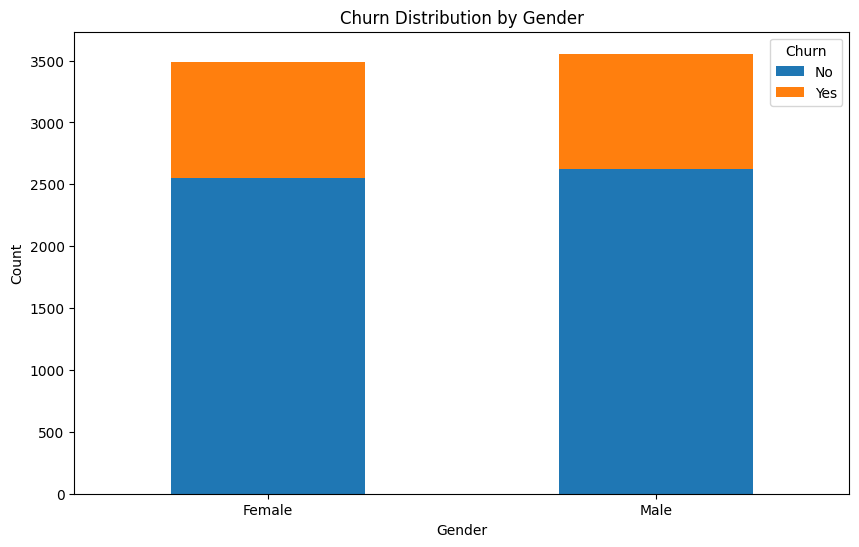

In [35]:
churn_gender_pd.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Churn Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Churn')
plt.show()

Calculating the churn rate

In [36]:
churn_rate = df_customer.groupBy('Churn').count()
total_customers = df_customer.count()
churn_rate = churn_rate.withColumn('Percentage', (col('count') / total_customers) * 100)

churn_rate.show()

+-----+-----+------------------+
|Churn|count|        Percentage|
+-----+-----+------------------+
|   No| 5174|  73.4630129206304|
|  Yes| 1869|26.536987079369588|
+-----+-----+------------------+



Tenure distribution for churned vs no-churned customers. when tenure is short term, the churning rate is high

In [37]:
tenure_churn_pd = df_customer.select('tenure', 'Churn').toPandas()

Plotting for histogram chart

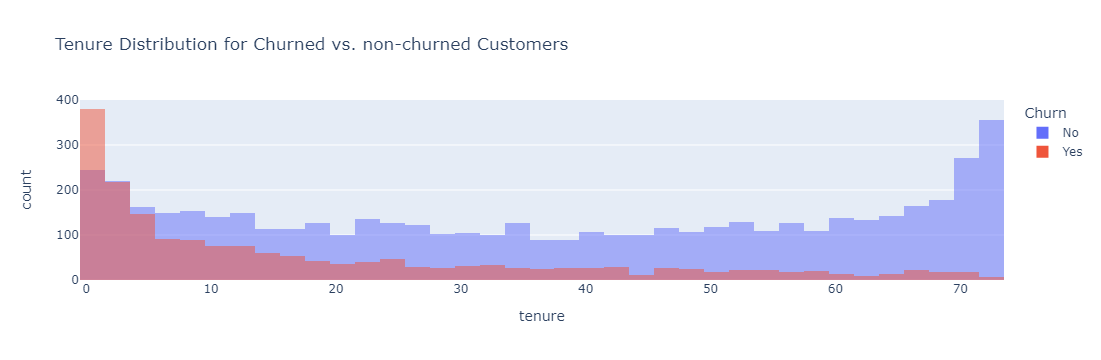

In [38]:
fig = px.histogram(tenure_churn_pd, x='tenure', color='Churn', barmode='overlay',
title='Tenure Distribution for Churned vs. non-churned Customers')
fig.show()

In [39]:
contract_churn = df_customer.groupBy('Contract').pivot('Churn').count()
contract_churn.show()

+--------------+----+----+
|      Contract|  No| Yes|
+--------------+----+----+
|Month-to-month|2220|1655|
|      One year|1307| 166|
|      Two year|1647|  48|
+--------------+----+----+



contract type vs churn

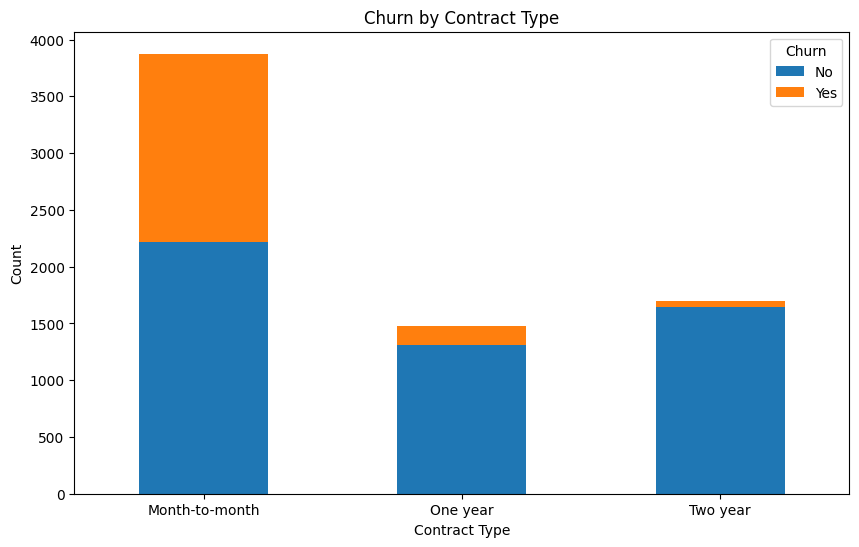

In [40]:
contract_churn_pd = contract_churn.toPandas().set_index('Contract')
contract_churn_pd.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Churn')
plt.show()

Payment Method vs Churn

In [41]:
contract_churn = df_customer.groupBy('Contract').pivot('Churn').count()
contract_churn.show()

+--------------+----+----+
|      Contract|  No| Yes|
+--------------+----+----+
|Month-to-month|2220|1655|
|      One year|1307| 166|
|      Two year|1647|  48|
+--------------+----+----+



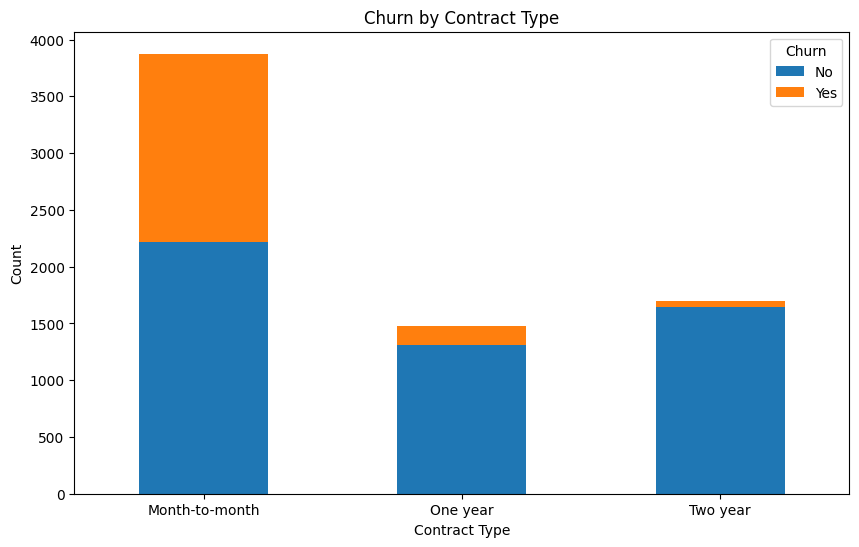

In [42]:
contract_churn_pd = contract_churn.toPandas().set_index('Contract')
contract_churn_pd.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Churn')
plt.show()

Storing numerical columsns in Pandas DF to create a histogram distribution

In [43]:
numerical_columns = ['tenure', 'TotalCharges']

In [44]:
df_pandas=df_customer.select(numerical_columns).toPandas()
df_pandas.head()

,tenure,TotalCharges
0,1,29.85
1,34,1889.5
2,2,108.15
3,45,1840.75
4,2,151.65


Creating histogram to analyse the distribution

To check any outlier in by histogram distribution

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

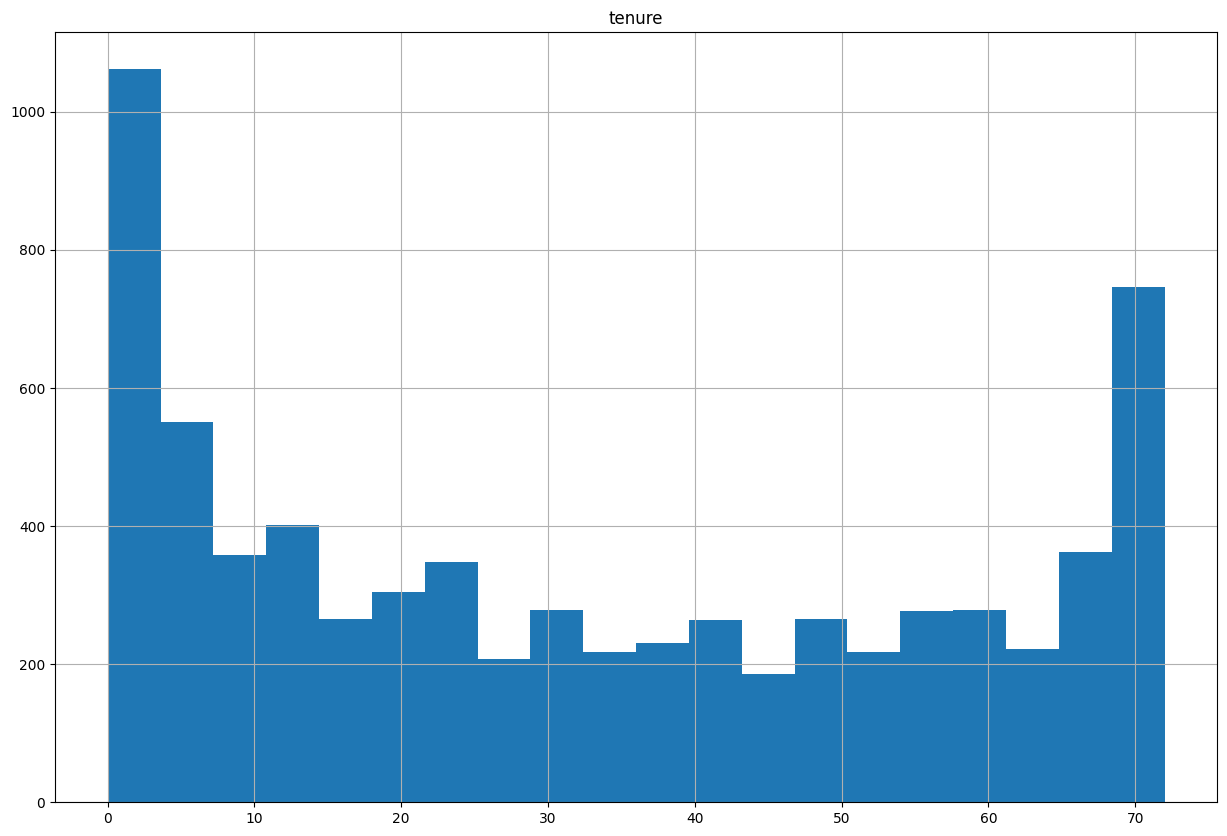

In [45]:
fig=plt.figure(figsize=(15,10))
ax=fig.gca()
df_pandas.hist(ax=ax , bins=20)
df_pandas.tenure.describe()

# Data cleaining and feature selection

Converting total charges into float as it was in string

In [46]:
df_customer = df_customer.withColumn("TotalCharges", when(col("TotalCharges").rlike(r'^\d+\.?\d*$'), col("TotalCharges")).otherwise(None))
df_customer = df_customer.withColumn("TotalCharges", col("TotalCharges").cast("float"))


Checking missing values

In [47]:
for column in df_customer.columns:
    df_customer.select(count(when(col(column).isNull(),column)).alias(column)).show()

+----------+
|customerID|
+----------+
|         0|
+----------+

+------+
|gender|
+------+
|     0|
+------+

+-------------+
|SeniorCitizen|
+-------------+
|            0|
+-------------+

+----------+
|Dependents|
+----------+
|         0|
+----------+

+------+
|tenure|
+------+
|     0|
+------+

+------------+
|PhoneService|
+------------+
|           0|
+------------+

+-------------+
|MultipleLines|
+-------------+
|            0|
+-------------+

+------------+
|OnlineBackup|
+------------+
|           0|
+------------+

+----------------+
|DeviceProtection|
+----------------+
|               0|
+----------------+

+-----------+
|TechSupport|
+-----------+
|          0|
+-----------+

+---------------+
|StreamingMovies|
+---------------+
|              0|
+---------------+

+--------+
|Contract|
+--------+
|       0|
+--------+

+----------------+
|PaperlessBilling|
+----------------+
|               0|
+----------------+

+-------------+
|PaymentMethod|
+-------------+
|   

Creating imputer for total charges as it has missing values

In [48]:
imputer = Imputer(inputCols=['TotalCharges'], outputCols=['TotalCharges'], strategy="mean")
df_customer = imputer.fit(df_customer).transform(df_customer)
df_customer.show()

+----------+------+-------------+----------+------+------------+----------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+------------+-----+
|customerID|gender|SeniorCitizen|Dependents|tenure|PhoneService|   MultipleLines|       OnlineBackup|   DeviceProtection|        TechSupport|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|TotalCharges|Churn|
+----------+------+-------------+----------+------+------------+----------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+------------+-----+
|7590-VHVEG|Female|            0|        No|     1|          No|No phone service|                Yes|                 No|                 No|                 No|Month-to-month|             Yes|    Electronic check|       29.85|   No|
|5575-GNVDE|  Male|            0|        No|    34|         Yes|

# Feature Selection

creating a list including all categorical columns and numerical columns

Didn't include the churn coulmn as it will be the output

In [49]:

categorical_columns = ['gender', 'SeniorCitizen', 'Dependents', 'PhoneService', 'MultipleLines', 
                       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingMovies', 
                       'Contract', 'PaperlessBilling', 'PaymentMethod']

Converting categorical columns into numerical data by using StringIndexer

In [50]:
indexers = [StringIndexer(inputCol=column, outputCol=column + "_Indexed") for column in categorical_columns]


VectorAssembler

In [51]:
# Define feature columns and assemble them as a vector
assembler_inputs = [name + "_Indexed" for name in categorical_columns] + numerical_columns
vector_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")


Converting churn column into numerical column

In [52]:
label_indexer = StringIndexer(inputCol="Churn", outputCol="label")

creating and applying the pipeline

In [53]:
pipeline = Pipeline(stages=indexers + [vector_assembler, label_indexer])

Testing and showing the dataset

In [54]:
df_model = pipeline.fit(df_customer).transform(df_customer)

In [55]:
df_model.toPandas()

,customerID,gender,SeniorCitizen,Dependents,tenure,PhoneService,MultipleLines,OnlineBackup,DeviceProtection,TechSupport,...,MultipleLines_Indexed,OnlineBackup_Indexed,DeviceProtection_Indexed,TechSupport_Indexed,StreamingMovies_Indexed,Contract_Indexed,PaperlessBilling_Indexed,PaymentMethod_Indexed,features,label
0,7590-VHVEG,Female,0,No,1,No,No phone service,Yes,No,No,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, ...",0.0
1,5575-GNVDE,Male,0,No,34,Yes,No,No,Yes,No,...,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0.0
2,3668-QPYBK,Male,0,No,2,Yes,No,Yes,No,No,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1.0
3,7795-CFOCW,Male,0,No,45,No,No phone service,No,Yes,Yes,...,2.0,0.0,1.0,1.0,0.0,2.0,1.0,2.0,"[0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, ...",0.0
4,9237-HQITU,Female,0,No,2,Yes,No,No,No,No,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,24,Yes,Yes,No,Yes,Yes,...,1.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",0.0
7039,2234-XADUH,Female,0,Yes,72,Yes,Yes,Yes,Yes,No,...,1.0,1.0,1.0,0.0,1.0,2.0,0.0,3.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",0.0
7040,4801-JZAZL,Female,0,Yes,11,No,No phone service,No,No,No,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
7041,8361-LTMKD,Male,1,No,4,Yes,Yes,No,No,No,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"(0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1.0


# Model Building

Train and test data splitting

In [56]:
train_data, test_data = df_model.randomSplit([0.7, 0.3], seed=100)
print("training Dataset count :" ,train_data.count())
print("testing Dataset count :" ,test_data.count())

training Dataset count : 4931
testing Dataset count : 2112


Creating and training my decision tree model

In [57]:
dtc = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=3)
model = dtc.fit(train_data)

Prediction using trained model

In [58]:
predictions = model.transform(test_data)

Raw prediction for each possible label, larger raw prediction=more confident

In [59]:
predictions.toPandas()

,customerID,gender,SeniorCitizen,Dependents,tenure,PhoneService,MultipleLines,OnlineBackup,DeviceProtection,TechSupport,...,TechSupport_Indexed,StreamingMovies_Indexed,Contract_Indexed,PaperlessBilling_Indexed,PaymentMethod_Indexed,features,label,rawPrediction,probability,prediction
0,0011-IGKFF,Male,1,No,13,Yes,No,Yes,Yes,No,...,0.0,1.0,0.0,0.0,0.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...",1.0,"[599.0, 385.0]","[0.608739837398374, 0.391260162601626]",0.0
1,0017-DINOC,Male,0,No,54,No,No phone service,No,No,Yes,...,1.0,0.0,1.0,1.0,3.0,"(0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, ...",0.0,"[2075.0, 156.0]","[0.9300761990138952, 0.06992380098610489]",0.0
2,0017-IUDMW,Female,0,Yes,72,Yes,Yes,Yes,Yes,Yes,...,1.0,1.0,1.0,0.0,3.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,"[2075.0, 156.0]","[0.9300761990138952, 0.06992380098610489]",0.0
3,0019-GFNTW,Female,0,No,56,No,No phone service,Yes,Yes,Yes,...,1.0,0.0,1.0,1.0,2.0,"[1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, ...",0.0,"[2075.0, 156.0]","[0.9300761990138952, 0.06992380098610489]",0.0
4,0020-INWCK,Female,0,Yes,71,Yes,Yes,Yes,Yes,No,...,0.0,1.0,1.0,0.0,3.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",0.0,"[2075.0, 156.0]","[0.9300761990138952, 0.06992380098610489]",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,9972-EWRJS,Female,0,Yes,67,Yes,No,No internet service,No internet service,No internet service,...,2.0,2.0,1.0,0.0,2.0,"[1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, ...",0.0,"[2075.0, 156.0]","[0.9300761990138952, 0.06992380098610489]",0.0
2108,9972-VAFJJ,Female,1,No,53,Yes,No,Yes,Yes,Yes,...,1.0,0.0,2.0,0.0,0.0,"(1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...",0.0,"[2075.0, 156.0]","[0.9300761990138952, 0.06992380098610489]",0.0
2109,9975-GPKZU,Male,0,Yes,46,Yes,No,No internet service,No internet service,No internet service,...,2.0,2.0,1.0,1.0,3.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, ...",0.0,"[2075.0, 156.0]","[0.9300761990138952, 0.06992380098610489]",0.0
2110,9985-MWVIX,Female,0,No,1,Yes,No,No,No,No,...,0.0,0.0,0.0,0.0,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"[328.0, 558.0]","[0.37020316027088035, 0.6297968397291196]",1.0


In [60]:
#printing decision tree rules
print(model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_cf6d1e30abe5, depth=3, numNodes=7, numClasses=2, numFeatures=14
  If (feature 9 in {1.0,2.0})
   Predict: 0.0
  Else (feature 9 not in {1.0,2.0})
   If (feature 7 in {1.0,2.0})
    Predict: 0.0
   Else (feature 7 not in {1.0,2.0})
    If (feature 12 <= 10.5)
     Predict: 1.0
    Else (feature 12 > 10.5)
     Predict: 0.0



# Evaluation

Evaluating using MultiClassificationEvaluator and test set accuracy

In [61]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test set accuracy: {accuracy}")

Test set accuracy: 0.7845643939393939


In [62]:
#Evaluating the performance of MulticlassClassificationEvaluator using key metrics
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print("Precision = %g" % precision)
print("Recall = %g" % recall)
print("F1 Score = %g" % f1)

Precision = 0.768283
Recall = 0.784564
F1 Score = 0.769538


Evaluating again using BinaryClassificationEvaluator and Area under the curve

In [63]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")

auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

AUC: 0.7971175917435213


In [64]:
#Predictions DataFrame is being transformed in RDD
predictionAndLabels = predictions.select("prediction", "label").rdd

Converting 'predictions' to RDD dataframe

In [65]:
predictionAndLabels = predictions.select("prediction", "label").rdd.map(lambda row: (row.prediction, row.label))
predictionAndLabels
#Converting the predictions DataFrame to an RDD of tuples

PythonRDD[602] at RDD at PythonRDD.scala:53

In [66]:
#Using 'collect' to show the content of RDD 
for pred, label in predictionAndLabels.collect():
    print(f"Prediction: {pred}, Actual Label: {label}")

Prediction: 0.0, Actual Label: 1.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 1.0, Actual Label: 1.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 1.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 1.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 1.0, Actual Label: 0.0
Prediction: 0.0, Actual Label: 0.0
Prediction: 0.0, Act

In [67]:
#Creating a MulticlassMetrics object to develop the Confusion Matrix
metrics = MulticlassMetrics(predictionAndLabels)

C:\Users\rabby\anaconda3\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



In [68]:
#Printing the confusion metrics
confusionMatrix = metrics.confusionMatrix()
print("Confusion Matrix:\n", confusionMatrix)

Confusion Matrix:
 DenseMatrix([[1426.,  139.],
             [ 316.,  231.]])


# Using Scikit-learn package to get a detailed classification report

In [69]:
#Taking 'Predictions' dtaframe to Pandas DF
predictions_pd_1 = predictions.select("prediction", "label").toPandas()

In [70]:
#Calculating the classification report
report1 = classification_report(predictions_pd_1["prediction"], predictions_pd_1["label"])
print("Classification Report:")
print(report1)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.82      0.86      1742
         1.0       0.42      0.62      0.50       370

    accuracy                           0.78      2112
   macro avg       0.67      0.72      0.68      2112
weighted avg       0.83      0.78      0.80      2112



Using RandomForestClassifier to again evualting the model

Again traing and testing data

In [71]:
rfc = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)

In [72]:
#fiting random forest model to train data
rfc_model = rfc.fit(train_data)


In [73]:
#getting the prediction
rfc_predictions = rfc_model.transform(test_data)


Evaluating the model using MulticlassClassificationEvaluator and determining the Test set accuracy

In [74]:
rfc_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rfc_accuracy = rfc_evaluator.evaluate(rfc_predictions)
print(f"Test set accuracy of Random Forest: {rfc_accuracy}")

Test set accuracy of Random Forest: 0.7935606060606061


Evaluating the performance of a Random Forest classifier using key metrics

In [75]:
rfc_precision = rfc_evaluator.evaluate(rfc_predictions, {rfc_evaluator.metricName: "weightedPrecision"})
rfc_recall = rfc_evaluator.evaluate(rfc_predictions, {rfc_evaluator.metricName: "weightedRecall"})
rfc_f1 = rfc_evaluator.evaluate(rfc_predictions, {rfc_evaluator.metricName: "f1"})
print(f"Precision of Random Forest: {rfc_precision}")
print(f"Recall of Random Forest: {rfc_recall}")
print(f"F1 Score of Random Forest: {rfc_f1}")

Precision of Random Forest: 0.7783916245946584
Recall of Random Forest: 0.793560606060606
F1 Score of Random Forest: 0.7764433586316711


In [76]:
rfc_predictions_pd = rfc_predictions.select("prediction", "label").toPandas()

# Generating and printing classification report

In [77]:
#Calculating classification report
rfc_report = classification_report(rfc_predictions_pd["label"], rfc_predictions_pd["prediction"])
print("Classification Report for Random Forest:")
print(rfc_report)

Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87      1565
         1.0       0.66      0.42      0.51       547

    accuracy                           0.79      2112
   macro avg       0.74      0.67      0.69      2112
weighted avg       0.78      0.79      0.78      2112



In [78]:
contingency_table = df_customer.groupBy('Contract').pivot('Churn').count()

# Showing the contingency table
contingency_table.show()

+--------------+----+----+
|      Contract|  No| Yes|
+--------------+----+----+
|Month-to-month|2220|1655|
|      One year|1307| 166|
|      Two year|1647|  48|
+--------------+----+----+



In [79]:
contingency_table = df_customer.groupBy('Tenure').pivot('Churn').count()

# Showing the contingency table for Tenure
contingency_table.show()

+------+---+---+
|Tenure| No|Yes|
+------+---+---+
|    31| 49| 16|
|    65| 67|  9|
|    53| 56| 14|
|    34| 53| 12|
|    28| 45| 12|
|    27| 59| 13|
|    26| 64| 15|
|    44| 45|  6|
|    12| 79| 38|
|    22| 63| 27|
|    47| 54| 14|
|     1|233|380|
|    52| 72|  8|
|    13| 71| 38|
|     6| 70| 40|
|    16| 52| 28|
|     3|106| 94|
|    40| 51| 13|
|    20| 53| 18|
|    57| 57|  8|
+------+---+---+
only showing top 20 rows



In [80]:
contingency_table = df_customer.groupBy('SeniorCitizen').pivot('Churn').count()

# Showing the contingency table for senior citizen
contingency_table.show()

+-------------+----+----+
|SeniorCitizen|  No| Yes|
+-------------+----+----+
|            1| 666| 476|
|            0|4508|1393|
+-------------+----+----+



In [90]:
contingency_table = df_customer.groupBy('OnlineBackup').pivot('Churn').count()

# Showing the contingency table for senior citizen
contingency_table.show()

+-------------------+----+----+
|       OnlineBackup|  No| Yes|
+-------------------+----+----+
|                 No|1855|1233|
|                Yes|1906| 523|
|No internet service|1413| 113|
+-------------------+----+----+



In [91]:
contingency_table = df_customer.groupBy('PaymentMethod').pivot('Churn').count()

# Showing the contingency table for senior citizen
contingency_table.show()

+--------------------+----+----+
|       PaymentMethod|  No| Yes|
+--------------------+----+----+
|Credit card (auto...|1290| 232|
|        Mailed check|1304| 308|
|Bank transfer (au...|1286| 258|
|    Electronic check|1294|1071|
+--------------------+----+----+



In [92]:
contingency_table = df_customer.groupBy('PhoneService').pivot('Churn').count()

# Showing the contingency table for senior citizen
contingency_table.show()

+------------+----+----+
|PhoneService|  No| Yes|
+------------+----+----+
|          No| 512| 170|
|         Yes|4662|1699|
+------------+----+----+



Converting Tenure numerical data into categorical data to get a proper prediction for churn

In [81]:
import pandas as pd
import numpy as np

# Simulating the DataFrame including 'Churn' column for demonstration
df = pd.DataFrame({
    'tenure': np.random.randint(0, 72, size=100),
    'Churn': np.random.choice(['Yes', 'No'], size=100)
})

# Defining bins and names for those bins
bins = [0, 12, 48, np.inf]
names = ['Short-term', 'Medium-term', 'Long-term']

# Using cut function to categorize 'tenure'
df['tenure_category'] = pd.cut(df['tenure'], bins=bins, labels=names, right=False)

# Analyzing churn by tenure category
churn_by_tenure = df.groupby('tenure_category')['Churn'].value_counts(normalize=True).unstack().fillna(0)

# Converting churn rates to percentages for better readability
churn_by_tenure_percentage = churn_by_tenure * 100

print("Churn Rate by Tenure Category:")
print(churn_by_tenure_percentage)

Churn Rate by Tenure Category:
Churn                   No        Yes
tenure_category                      
Short-term       33.333333  66.666667
Medium-term      58.000000  42.000000
Long-term        46.875000  53.125000


C:\Users\rabby\AppData\Local\Temp\ipykernel_7504\828702428.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Converting 'Total charges' numerical data into categorical data to get a proper prediction for churn

In [82]:
import pandas as pd

# Converting the Spark DataFrame to a Pandas DataFrame
df_customer_pd = df_customer.toPandas()

# Defining the bins and labels
bins = [0, 1000, 3500, float('inf')]
labels = ['Low Charge', 'Medium Charge', 'High Charge']

# Using pd.cut to categorize 'TotalCharges'
df_customer_pd['TotalCharges_category'] = pd.cut(df_customer_pd['TotalCharges'], bins=bins, labels=labels, include_lowest=True)

# group by 'TotalCharges_category' and 'Churn' to analyze churn rate across charge categories
churn_analysis = df_customer_pd.groupby(['TotalCharges_category', 'Churn']).size().unstack(fill_value=0)

# Calculating churn rate as the number of churned customers divided by the total number of customers in each category
churn_analysis['Churn_Rate'] = churn_analysis['Yes'] / (churn_analysis['Yes'] + churn_analysis['No'])

print(churn_analysis)

Churn                    No   Yes  Churn_Rate
TotalCharges_category                        
Low Charge             1823  1070    0.369858
Medium Charge          1723   517    0.230804
High Charge            1628   282    0.147644


C:\Users\rabby\AppData\Local\Temp\ipykernel_7504\1259831884.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Using Multiple variables to predict churn which are relevant

In [83]:
import pandas as pd

# Simulating the DataFrame setup
df_customer_pd = pd.DataFrame({
    'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], size=7000),
    'TotalCharges': np.random.uniform(0, 8000, size=7000),
    'Tenure': np.random.randint(0, 72, size=7000),
    'Churn': np.random.choice(['Yes', 'No'], size=7000)
})

# Defining bins and names for 'TotalCharges' and 'Tenure'
total_charge_bins = [0, 1000, 3500, float('inf')]
total_charge_names = ['Low', 'Medium', 'High']

tenure_bins = [0, 12, 48, np.inf]
tenure_names = ['Short-term', 'Medium-term', 'Long-term']

# Categorizing 'TotalCharges' and 'Tenure'
df_customer_pd['TotalCharges_category'] = pd.cut(df_customer_pd['TotalCharges'], bins=total_charge_bins, labels=total_charge_names, include_lowest=True)
df_customer_pd['Tenure_category'] = pd.cut(df_customer_pd['Tenure'], bins=tenure_bins, labels=tenure_names, include_lowest=True)

# Creating the cross-tabulation
multiple_ct = pd.crosstab([df_customer_pd['Tenure_category'], df_customer_pd['TotalCharges_category']], df_customer_pd['Contract'], margins=False)

print(multiple_ct)

Contract                               Month-to-month  One year  Two year
Tenure_category TotalCharges_category                                    
Short-term      Low                                55        54        50
                Medium                            152       128       134
                High                              244       265       225
Medium-term     Low                               163       150       139
                Medium                            423       349       328
                High                              645       629       652
Long-term       Low                                96        99        88
                Medium                            213       231       220
                High                              417       413       438


Now predicting the churn based on these multivariables

In [84]:
churn_ct = pd.crosstab([df_customer_pd['Tenure_category'], df_customer_pd['TotalCharges_category'],df_customer_pd['Contract'] ], df_customer_pd['Churn'], margins=False)
print(churn_ct)

Churn                                                  No  Yes
Tenure_category TotalCharges_category Contract                
Short-term      Low                   Month-to-month   32   23
                                      One year         25   29
                                      Two year         22   28
                Medium                Month-to-month   76   76
                                      One year         63   65
                                      Two year         77   57
                High                  Month-to-month  119  125
                                      One year        136  129
                                      Two year        118  107
Medium-term     Low                   Month-to-month   72   91
                                      One year         74   76
                                      Two year         67   72
                Medium                Month-to-month  209  214
                                      One year        1

In [85]:
#Stopping the spark session
spark.stop()